In [1]:
import os
import re
import h5py
import numpy as np
import configparser
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Constant

In [2]:
HEADER_SIZE = 1159544
METADATA_SIZE = 554
SV_SCAN_SIZE = 25930
VOC_SCAN_SIZE = 17290
BB_SCAN_SIZE = 8650
TRANSPORT_BLOCK_SIZE = 9216
KM_DATA_SIZE = 2304

SYNCHROSERIES_SIZE = 10

SENSORS_COUNT = 40

# Colibrators
SV_BLOCK_SIZE = 216
SV_DN_INLINE_COUNT = 144

VOC_BLOCK_SIZE = 144
VOC_DN_INLINE_COUNT = 96

BB_BLOCK_SIZE = 72
BB_DN_INLINE_COUNT = 48

In [3]:
config = configparser.ConfigParser()
config.read('file_paths.ini')
config.sections()

['MAIN_DATA_PATH', 'FY3', 'HIMAWARI']

In [4]:
# File paths for FengYun-3E data.
FY3E_DATA_FOLDERS_LOCATION = config['FY3']['FY3E_MAIN_DATA_LOCATION']
FY3E_RAW_DATA_LOCATION = config['FY3']['FY3E_RAW_DATA_LOCATION']
FY3E_L0_DATA_LOCATION = config['FY3']['FY3E_L0_DATA_LOCATION']
FY3E_L1_DATA_LOCATION = config['FY3']['FY3E_L1_DATA_LOCATION']
FY3E_L1_GOE_DATA_LOCATION = config['FY3']['FY3E_L1_GOE_DATA_LOCATION']
FY3E_L1_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_IMAGE_DATA_LOCATION']
FY3E_L1_GEOREF_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_GEOREF_IMAGE_DATA_LOCATION']

In [5]:
fy3e_L0_files_paths = [FY3E_L0_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L0_DATA_LOCATION)]
fy3e_l1_geo_files_paths = [FY3E_L1_GOE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_GOE_DATA_LOCATION)]
fy3e_l1_image_files_paths = [FY3E_L1_IMAGE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_IMAGE_DATA_LOCATION)]

print('L0 files -', fy3e_L0_files_paths)
print()
print('GEO files -', fy3e_l1_geo_files_paths)
print()
print('Image files -', fy3e_l1_image_files_paths)

L0 files - ['E:/Satellite data/FY-3E/L0/Y3E_08534_230226070855_7860R_MERSI.DAT']

GEO files - ['E:/Satellite data/FY-3E/L1/geo/FY3E_MERSI_GRAN_L1_20230228_2215_GEOQK_V0.HDF']

Image files - ['E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230228_2215_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20240301_0915_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0435_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0935_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0520_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0840_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0845_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1020_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1745_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_2100_0250

In [6]:
def find_synchroseries(byte_line: bytes) -> np.array:
    synchroseries = b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d'
    return np.array([i.start() for i in re.finditer(synchroseries, byte_line)])

In [7]:
def read_uint12(data_chunk):
    data = np.frombuffer(data_chunk, dtype=np.uint8)
    fst_uint8, mid_uint8, lst_uint8 = np.reshape(data, (data.shape[0] // 3, 3)).astype(np.uint16).T
    fst_uint12 = (fst_uint8 << 4) + (mid_uint8 >> 4)
    snd_uint12 = ((mid_uint8 % 16) << 8) + lst_uint8
    return np.reshape(np.concatenate((fst_uint12[:, None], snd_uint12[:, None]), axis=1), 2 * fst_uint12.shape[0])

In [8]:
l0_data = open(fy3e_L0_files_paths[0], 'br')

In [9]:
data = l0_data.read(HEADER_SIZE)

In [10]:
section_1, section_2 = [], []
section_3, section_4, section_5, section_6, section_7 = [], [], [], [], []

data2_agg, data3_agg, data4_agg, data5_agg = [], [], [], []

for _ in range(500):
    data2 = l0_data.read(METADATA_SIZE)
    data2_agg.append(data2)

    data3 = l0_data.read(SV_SCAN_SIZE)
    data3_agg.append(data3)

    data4 = l0_data.read(VOC_SCAN_SIZE)
    data4_agg.append(data4)

    data5 = l0_data.read(BB_SCAN_SIZE)
    data5_agg.append(data5)
    
    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        section_1.append(read_uint12(data))

    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        section_2.append(read_uint12(data))
        
    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        
        section_3.append(read_uint12(data[:KM_DATA_SIZE]))
        section_4.append(read_uint12(data[KM_DATA_SIZE:KM_DATA_SIZE * 2]))
        section_5.append(read_uint12(data[KM_DATA_SIZE * 2:KM_DATA_SIZE * 3]))
        section_6.append(read_uint12(data[KM_DATA_SIZE * 3:KM_DATA_SIZE * 4]))


section_1 = np.array(section_1)
section_2 = np.array(section_2)
section_3 = np.array(section_3)
section_4 = np.array(section_4)
section_5 = np.array(section_5)
section_6 = np.array(section_6)

### Space view data

In [11]:
sv_b6_data = []
sv_b7_data = []
sv_1km_data = []
for i, sv_block_all in enumerate(data3_agg):
    sv_block_all_no_synh = sv_block_all[SYNCHROSERIES_SIZE:]
    
    sv_blocks = []
    for block_index in range(0, SV_SCAN_SIZE - SYNCHROSERIES_SIZE, SV_BLOCK_SIZE):
        sv_blocks.append(read_uint12(sv_block_all_no_synh[block_index:block_index + SV_BLOCK_SIZE]))

    sv_blocks = np.array(sv_blocks)

    sv_b6_data.append(sv_blocks[:SENSORS_COUNT])
    sv_b7_data.append(sv_blocks[SENSORS_COUNT:SENSORS_COUNT * 2])
    sv_1km_data.append(sv_blocks[SENSORS_COUNT * 2:SENSORS_COUNT * 3])

sv_b6_data = np.array(sv_b6_data)
sv_b7_data = np.array(sv_b7_data)
sv_1km_data = np.array(sv_1km_data)

In [13]:
sv_b6_data = sv_b6_data[2:]

In [14]:
sv_b6_data_1 = sv_b6_data[::2]
sv_b6_data_2 = sv_b6_data[1::2]

sv_b6_data_1_2 = np.stack([sv_b6_data_1, sv_b6_data_2])

In [15]:
sv_b6_mean_all = np.mean(sv_b6_data_1_2)
sv_b6_mean_all = np.full(2, sv_b6_mean_all)

In [16]:
sv_b6_sensors_mean = np.mean(sv_b6_data_1_2, axis=(1, 3))
sv_b6_sensors_mean

array([[108.42996752, 151.24092742, 117.24504368,  99.25526434,
        114.80118728, 112.97510641, 105.24876792, 103.68422379,
        113.98527106, 137.08949373, 121.66140233, 108.29278674,
        105.89406922, 119.43876008, 117.29777106, 125.86735551,
        101.08943772, 124.82120856, 127.59764225, 115.22208221,
        116.06796035,  93.85108647, 139.31306004,  89.40367384,
        126.01699709, 126.92086694, 108.83411738, 132.55482751,
        143.47547043, 129.93391577, 142.36606743, 129.98647513,
        104.9765345 , 135.91523858, 145.08730959, 132.73854727,
        130.66260641, 102.57798499, 130.44825269, 126.85850694],
       [108.95399306, 152.43237567, 117.71074149, 100.01635305,
        114.48865927, 113.35903898, 104.54925515, 104.07448477,
        112.86307124, 137.25708445, 120.75728047, 107.57090054,
        105.15258177, 118.14266913, 116.13771281, 124.35033042,
        100.40078965, 123.39138105, 127.33680556, 113.89765345,
        115.86519937,  92.12166779, 139

### Black body data

In [17]:
bb_b6_data = []
bb_b7_data = []
bb_1km_data = []
for i, bb_block_all in enumerate(data5_agg):
    bb_block_all_no_synh = bb_block_all[SYNCHROSERIES_SIZE:]
    
    bb_blocks = []
    for block_index in range(0, BB_SCAN_SIZE - SYNCHROSERIES_SIZE, BB_BLOCK_SIZE):
        bb_blocks.append(read_uint12(bb_block_all_no_synh[block_index:block_index + BB_BLOCK_SIZE]))

    bb_blocks = np.array(bb_blocks)

    bb_b6_data.append(bb_blocks[:SENSORS_COUNT])
    bb_b7_data.append(bb_blocks[SENSORS_COUNT:SENSORS_COUNT * 2])
    bb_1km_data.append(bb_blocks[SENSORS_COUNT * 2:SENSORS_COUNT * 3])

bb_b6_data = np.array(bb_b6_data)
bb_b7_data = np.array(bb_b7_data)
bb_1km_data = np.array(bb_1km_data)

In [18]:
bb_b6_data = bb_b6_data[2:]

In [19]:
bb_b6_data_1 = bb_b6_data[::2]
bb_b6_data_2 = bb_b6_data[1::2]

bb_b6_data_1_2 = np.stack([bb_b6_data_1, bb_b6_data_2])

In [20]:
bb_b6_mean_all = np.mean(bb_b6_data_1_2)
bb_b6_mean_all = np.full(2, bb_b6_mean_all)

In [21]:
bb_b6_sensors_mean = np.mean(bb_b6_data_1_2, axis=(1, 3))
bb_b6_sensors_mean

array([[1276.37407965, 1360.72690763, 1300.64190094, 1278.80538822,
        1297.86311914, 1287.79585007, 1306.02108434, 1276.7811245 ,
        1306.51564592, 1314.11546185, 1318.95799866, 1305.45983936,
        1278.51054217, 1315.01480924, 1300.54886212, 1328.97356091,
        1284.87349398, 1317.01656627, 1318.32212182, 1305.3206158 ,
        1309.03237952, 1298.31425703, 1321.07638889, 1289.50066934,
        1318.31333668, 1313.15160643, 1297.99740629, 1310.81057564,
        1340.96644913, 1311.11069277, 1335.09973226, 1309.77317604,
        1297.09052878, 1318.35065261, 1324.16942771, 1304.49330656,
        1312.98761714, 1280.52317604, 1315.09354083, 1310.37115127],
       [1218.7434739 , 1301.77752677, 1243.19009371, 1222.93557564,
        1241.73418675, 1234.48887216, 1253.63453815, 1226.98201138,
        1258.83391901, 1266.47406292, 1273.49782463, 1260.88194444,
        1236.05195783, 1271.30555556, 1256.72540161, 1285.60901941,
        1245.15855087, 1277.06927711, 1280.5065

In [22]:
alpha = (bb_b6_mean_all[..., None] - sv_b6_mean_all[..., None]) / (bb_b6_sensors_mean - sv_b6_sensors_mean)
beta = sv_b6_mean_all[..., None] - alpha * sv_b6_sensors_mean

In [23]:
section_1_corrected = np.zeros(section_1.shape)

for i in range(section_1.shape[0]):
    section_1_corrected[i] = np.round(alpha[(i // 40) % 2][i % 40] * section_1[i] + beta[(i // 40) % 2][i % 40])

In [24]:
plt.imsave('b6_new_4.png', section_1_corrected)

KeyboardInterrupt: 

In [105]:
plt.imsave('b6.png', section_1)

In [36]:
sv_b6_data_corrected = np.zeros(sv_b6_data.shape)

for i in range(sv_b6_data.shape[0]):
    sv_b6_data_corrected[i] = alpha[(i // 40) % 2][i % 40] * sv_b6_data[i] + beta[(i // 40) % 2][i % 40]

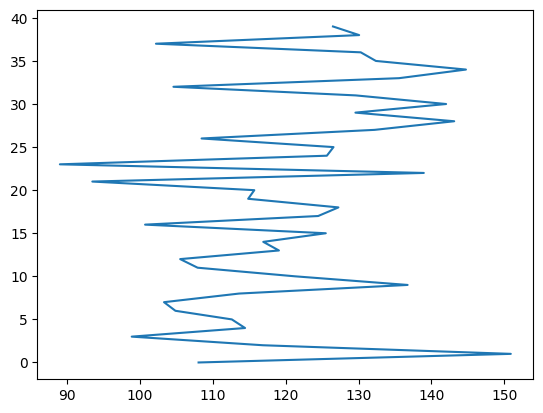

In [37]:
plt.plot(np.mean(sv_b6_data_corrected[::2], axis=(0, 2)), np.arange(40))

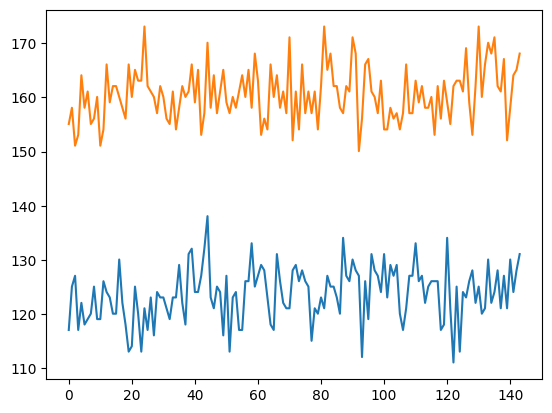

In [29]:
for i in range(2):
    plt.plot(np.arange(144), sv_b6_data_corrected[0][i])
    #plt.plot(np.arange(144), sv_b6_data_corrected[1][i])

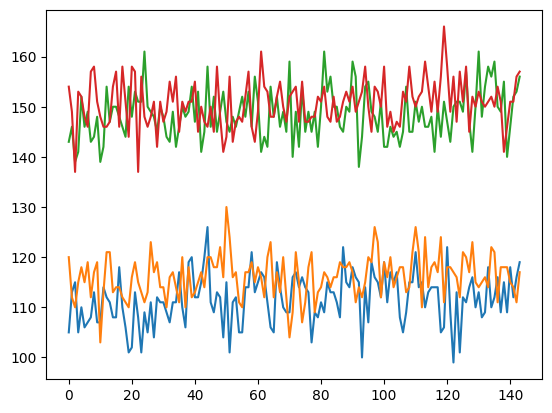

In [28]:
for i in range(2):
    plt.plot(np.arange(144), sv_b6_data[0][i])
    #plt.plot(np.arange(144), sv_b6_data[1][i])

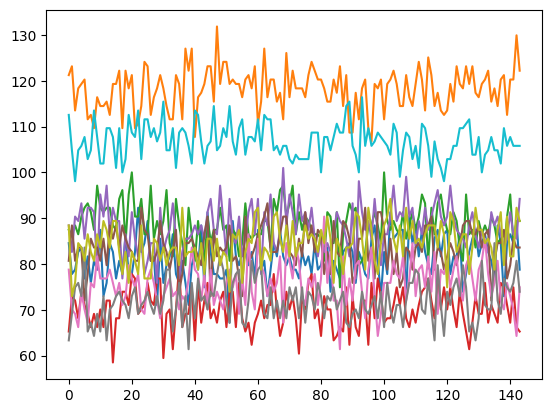

In [202]:
for i in range(10):
    plt.plot(np.arange(144), sv_b6_data_corrected[1][i])

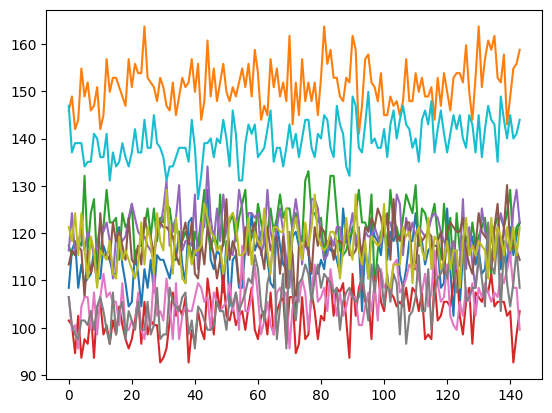

In [203]:
for i in range(10):
    plt.plot(np.arange(144), sv_b6_data_corrected[2][i])

In [190]:
alpha[1]

array([1.05218999, 1.01595854, 1.03751699, 1.03987684, 1.03590101,
       1.04153936, 1.0162019 , 1.03988004, 1.01896653, 1.03407983,
       1.01298645, 1.01247488, 1.03255183, 1.01259009, 1.02377018,
       1.00554277, 1.02003932, 1.01214727, 1.01260316, 1.01396763,
       1.00927824, 0.99908807, 1.01660467, 0.99993911, 1.00537484,
       1.0112055 , 1.00709696, 1.01680705, 1.00040126, 1.01858111,
       1.00263249, 1.01541739, 1.00362144, 1.01341663, 1.01453045,
       1.0198384 , 1.00946135, 1.01226923, 1.00451214, 1.00567406])

In [191]:
beta[1]

array([  5.86975506, -34.33256038,  -1.61140994,  16.51705512,
         1.90573648,   2.45069447,  14.27364544,  12.30533085,
         5.50981149, -21.41583878,  -1.81660125,  11.60814783,
        11.93172866,   0.90803851,   1.62145448,  -4.51541272,
        18.10875151,  -4.36274359,  -8.4255187 ,   5.03364207,
         3.56564194,  28.49969853, -21.62643324,  32.08876347,
        -6.8609869 ,  -6.4882555 ,  10.66284681, -13.07868119,
       -23.37767252, -11.08328455, -23.52325288, -11.60292414,
        13.57066122, -18.12208088, -29.11676869, -16.17264177,
       -13.75242745,  14.74502344, -12.43148157,  -9.19139507])

In [186]:
sv_b6_data_corrected[1]

array([[6.90086149, 6.90086149, 6.90086149, ..., 6.90086149, 6.90086149,
        6.90086149],
       [6.90086149, 6.90086149, 6.90086149, ..., 6.90086149, 6.90086149,
        6.90086149],
       [6.90086149, 6.90086149, 6.90086149, ..., 6.90086149, 6.90086149,
        6.90086149],
       ...,
       [6.90086149, 6.90086149, 6.90086149, ..., 6.90086149, 6.90086149,
        6.90086149],
       [6.90086149, 6.90086149, 6.90086149, ..., 6.90086149, 6.90086149,
        6.90086149],
       [6.90086149, 6.90086149, 6.90086149, ..., 6.90086149, 6.90086149,
        6.90086149]])

In [188]:
sv_b6_data[1]

array([[114, 107, 108, ..., 114, 119, 108],
       [152, 154, 144, ..., 151, 161, 153],
       [117, 116, 118, ..., 114, 119, 119],
       ...,
       [110, 113, 103, ..., 105, 112, 109],
       [134, 125, 136, ..., 136, 138, 134],
       [138, 128, 137, ..., 133, 138, 123]], dtype=uint16)

In [162]:
sv_data_by_scan_line = []
for i in sv_b6_data:
    for j in i:
        sv_data_by_scan_line.append(j)

sv_data_by_scan_line = np.array(sv_data_by_scan_line)

In [192]:
A = np.mean(sv_data_by_scan_line)

In [222]:
alpha = np.zeros(40)
beta = np.zeros(40)
for i in range(40):
    alpha[i] = 1
    beta[i] = np.mean(sv_data_by_scan_line[40 + i::40]) - A

In [197]:
sv_data_by_scan_line_correct = np.zeros(sv_data_by_scan_line.shape)

In [198]:
for i in range(sv_data_by_scan_line.shape[0]):
    sv_data_by_scan_line_correct[i] = sv_data_by_scan_line[i] * alpha[i % 40]

In [223]:
section_1_corrected = np.zeros(section_1.shape)

In [224]:
for i in range(section_1.shape[0]):
    section_1_corrected[i] = alpha[i % 40] * section_1[i] + beta[i % 40]

In [215]:
plt.imsave('b6.png', section_1)

In [225]:
plt.imsave('b6_corrected.png', section_1_corrected)

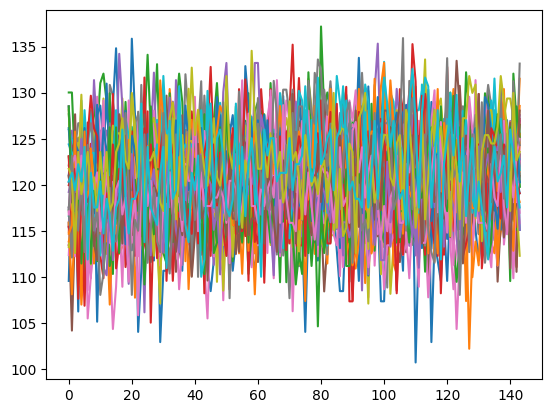

In [211]:
for i in range(40, 80):     
    plt.plot(np.arange(144), sv_data_by_scan_line_correct[i])

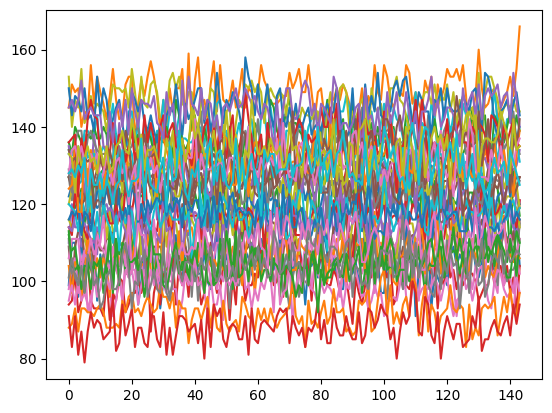

In [212]:
for i in range(40, 80):
    plt.plot(np.arange(144), sv_data_by_scan_line[i])

In [185]:
first_sensor = sv_data_by_scan_line[::40]
second_sensor = sv_data_by_scan_line[1::40]

In [186]:
A = np.mean(sv_data_by_scan_line)

In [187]:
alpha_first = A / np.mean(first_sensor)
alpha_second = A / np.mean(second_sensor)

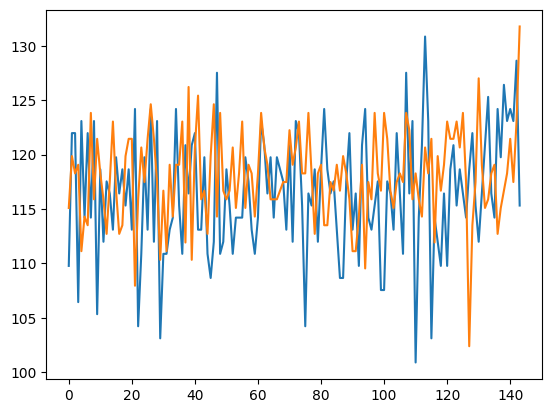

In [188]:
plt.plot(np.arange(144), alpha_first * first_sensor[1])
plt.plot(np.arange(144), alpha_second * second_sensor[1])

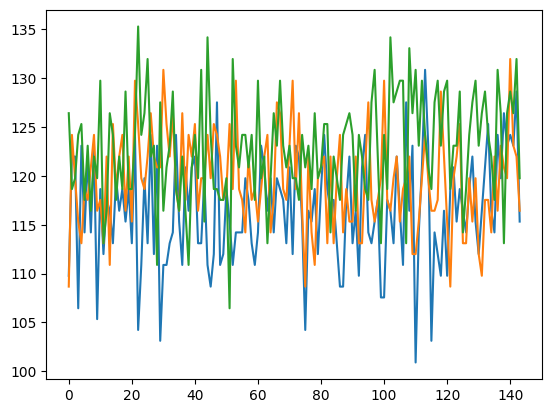

In [181]:
for i in range(1, 4):
    plt.plot(np.arange(144), alpha * first_sensor[i])

In [79]:
sensor_diff = []

for scan_line in sv_b6_data[1:]:
    scan_line_mean = np.mean(scan_line)
    sensors = []
    
    for sensor in range(40):
        sensor_mean = np.mean(scan_line[sensor])
        diff_dn_value = sensor_mean - scan_line_mean
        sensors.append(np.array([sensor_mean, diff_dn_value]))
    
    sensor_diff.append(sensors)

In [74]:
len(sensor_diff)

499

In [80]:
first_sensor = []

for line in sensor_diff:
    first_sensor.append(line[0])

first_sensor = np.array(first_sensor)

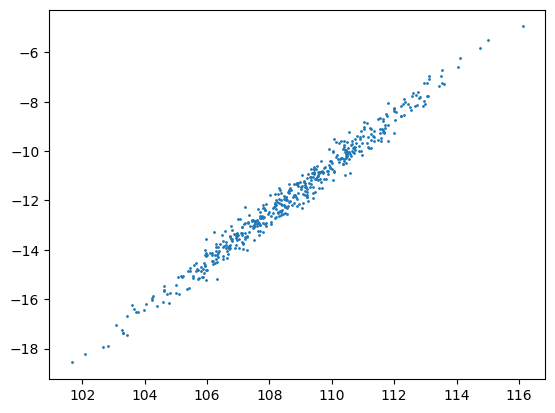

In [85]:
plt.scatter(first_sensor[:, 0], first_sensor[:, 1], s=1)

In [83]:
second_sensor = []

for line in sensor_diff:
    second_sensor.append(line[1])

second_sensor = np.array(second_sensor)

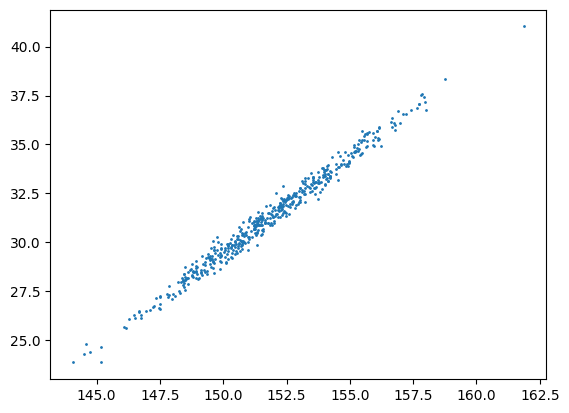

In [86]:
plt.scatter(second_sensor[:, 0], second_sensor[:, 1], s=1)

In [67]:
np.mean(sv_b6_data[1])

120.74236111111111

In [68]:
np.mean(sv_b6_data[1][0])

104.98611111111111

In [55]:
first_sensor = [sv_data_by_scan_line[i] for i in range(0, len(sv_data_by_scan_line), 40)]

In [62]:
np.mean(first_sensor)

108.68692941438432

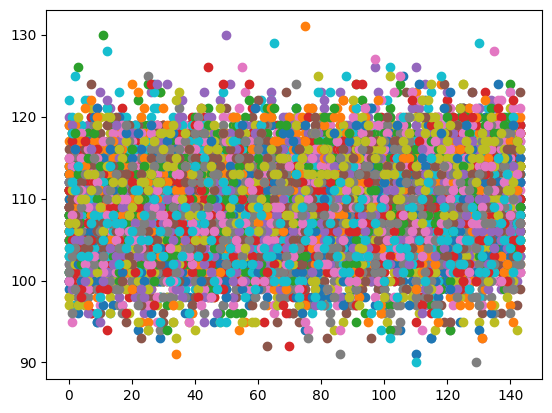

In [58]:
for i in first_sensor[:100]:
    plt.scatter(np.arange(144), i)
#plt.plot(np.arange(144), [np.mean(sv_data_by_scan_line)] * 144)

In [40]:
np.vstack(sv_data_by_scan_line[:2])

array([[ 99, 110, 110,  96, 111, 103, 110, 103, 111,  95, 107, 101, 106,
        105, 102, 108, 105, 107, 104, 107, 102, 112,  94, 100, 108, 102,
        112, 101, 111,  93, 100, 100, 102, 103, 112, 104, 100, 109, 105,
        109, 110, 102, 102, 108, 100,  98, 101, 115, 100, 101, 107, 104,
        100, 103, 103, 103, 108, 106, 102, 100, 103, 111, 109, 105, 108,
        103, 108, 107, 106, 102, 109, 101, 111, 110, 104,  94, 105, 104,
        107, 101, 107, 112, 107, 105, 106, 102,  98,  98, 106, 110, 102,
        105,  99, 109, 112, 103, 102, 104, 106,  97,  97, 106, 105, 102,
        110, 105, 100, 115, 105, 111,  91, 103, 109, 118, 111,  93, 103,
        101,  99, 105,  99, 107, 109, 104, 107, 105, 103, 107, 110, 104,
        101, 105, 109, 113, 105, 103, 112, 108, 114, 111, 112, 111, 116,
        104],
       [145, 151, 149, 150, 140, 144, 143, 156, 146, 153, 149, 146, 142,
        148, 155, 147, 142, 143, 151, 153, 153, 136, 146, 152, 148, 153,
        157, 153, 148, 139, 147, 140,

110

In [14]:
test_data3 = data3[1][10:]

In [15]:
sv_block_size = 216

In [16]:
sv_blocks = []
for block_index in range(0, 25920, sv_block_size):
    sv_blocks.append(read_uint12(test_data3[block_index:block_index + sv_block_size]))

sv_blocks = np.array(sv_blocks)

In [17]:
sv_blocks.shape

(120, 144)

In [18]:
sv_blocks[0]

array([ 99, 110, 110,  96, 111, 103, 110, 103, 111,  95, 107, 101, 106,
       105, 102, 108, 105, 107, 104, 107, 102, 112,  94, 100, 108, 102,
       112, 101, 111,  93, 100, 100, 102, 103, 112, 104, 100, 109, 105,
       109, 110, 102, 102, 108, 100,  98, 101, 115, 100, 101, 107, 104,
       100, 103, 103, 103, 108, 106, 102, 100, 103, 111, 109, 105, 108,
       103, 108, 107, 106, 102, 109, 101, 111, 110, 104,  94, 105, 104,
       107, 101, 107, 112, 107, 105, 106, 102,  98,  98, 106, 110, 102,
       105,  99, 109, 112, 103, 102, 104, 106,  97,  97, 106, 105, 102,
       110, 105, 100, 115, 105, 111,  91, 103, 109, 118, 111,  93, 103,
       101,  99, 105,  99, 107, 109, 104, 107, 105, 103, 107, 110, 104,
       101, 105, 109, 113, 105, 103, 112, 108, 114, 111, 112, 111, 116,
       104], dtype=uint16)

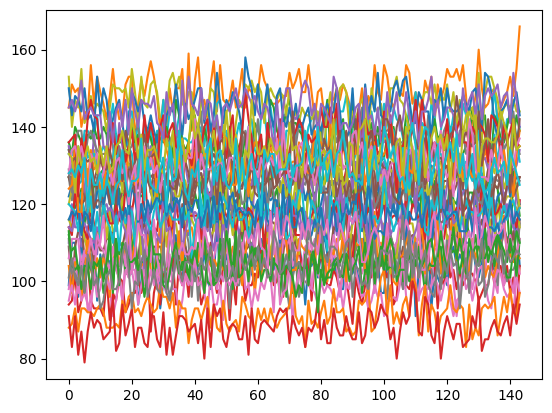

In [20]:
for i in range(40):
    plt.plot(np.arange(sv_blocks.shape[1]), sv_blocks[i])

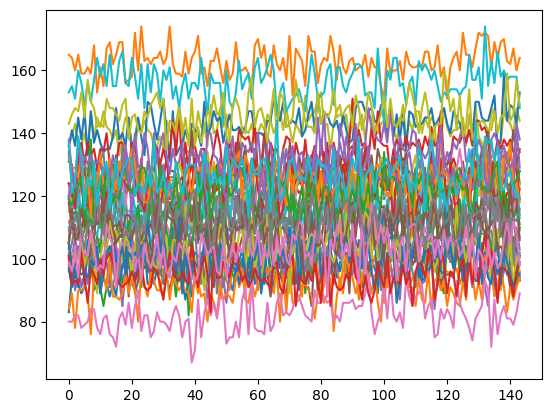

In [150]:
for i in range(40):
    plt.plot(np.arange(sv_blocks.shape[1]), sv_blocks[40 + i])

In [ ]:
for index, i in enumerate(sv_blocks[80:120]):
    

In [23]:
sv_blocks[80:120]

array([[ 200,  203,  199, ...,  181,  185,  185],
       [ 184,  187,  185, ...,  242,  241,  242],
       [ 173,  174,  173, ...,  146,  148,  146],
       ...,
       [2027, 2030, 2032, ..., 2069, 2045, 2055],
       [1960, 1976, 1989, ..., 2039, 2091, 2062],
       [1913, 1916, 1910, ..., 1962, 1962, 1973]], dtype=uint16)

In [205]:
sv_blocks[97:98][0][72:108]

array([1933, 1900, 1923, 1899, 1925, 1914, 1925, 1911, 1905, 1905, 1922,
       1931, 1935, 1943, 1922, 1939, 1954, 1937, 1942, 1953, 1952, 1955,
       1946, 1965, 1947, 1962, 1970, 1999, 1982, 1935, 1978, 1982, 1978,
       1973, 1991, 1984], dtype=uint16)

In [40]:
test_data4 = data3_agg[1][10:]

In [41]:
voc_block_size = 144

In [42]:
voc_blocks = []
for block_index in range(0, 17280, voc_block_size):
    voc_blocks.append(read_uint12(test_data4[block_index:block_index + voc_block_size]))

voc_blocks = np.array(voc_blocks)

In [43]:
voc_blocks.shape

(120, 96)

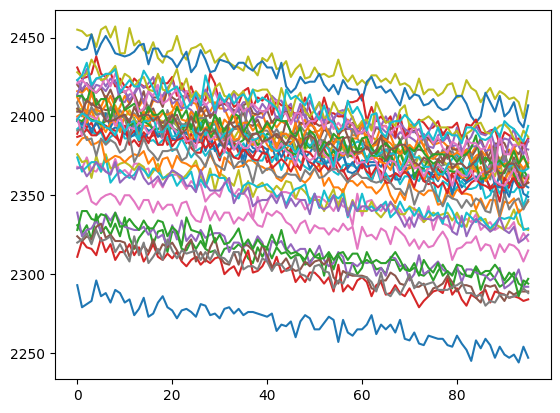

In [22]:
for i in range(40):
    plt.plot(np.arange(voc_blocks.shape[1]), voc_blocks[i])

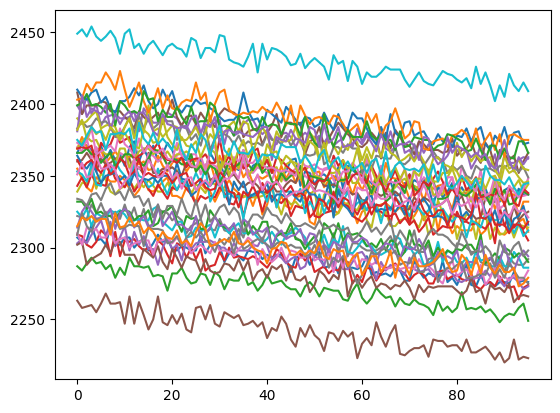

In [23]:
for i in range(40):
    plt.plot(np.arange(voc_blocks.shape[1]), voc_blocks[40 + i])

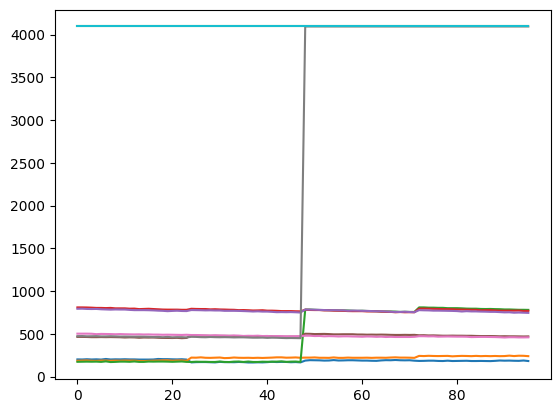

In [25]:
for i in range(10):
    plt.plot(np.arange(voc_blocks.shape[1]), voc_blocks[80 + i])

In [25]:
test_data5 = data4_agg[1][10:]

In [26]:
bb_block_size = 72

In [27]:
bb_blocks = []
for block_index in range(0, 8640, bb_block_size):
    bb_blocks.append(read_uint12(test_data5[block_index:block_index + bb_block_size]))

bb_blocks = np.array(bb_blocks)

In [28]:
bb_blocks.shape

(120, 48)

Найти среднее и станлартное отклонение

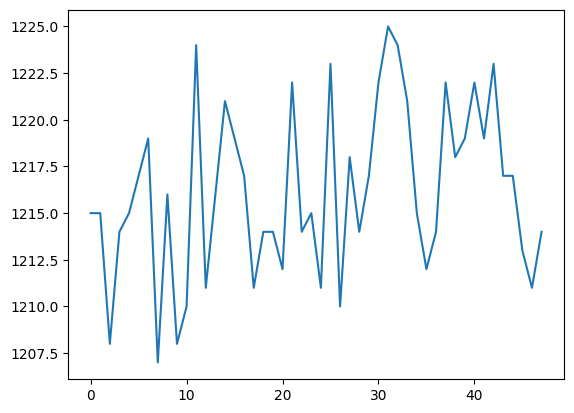

In [30]:
for i in range(1):
    plt.plot(np.arange(bb_blocks.shape[1]), bb_blocks[i])

In [34]:
np.mean(bb_blocks[0])

1216.1458333333333

In [46]:
np.std(bb_blocks[0])

4.573426793870094

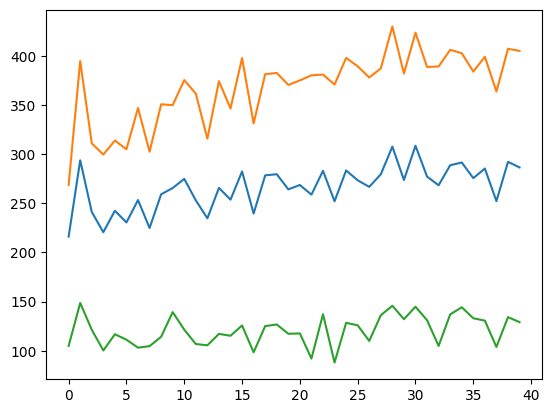

In [47]:
plt.plot(np.arange(40), np.mean(bb_blocks[:40], axis=1) - 1000)
plt.plot(np.arange(40), np.mean(voc_blocks[:40], axis=1) - 2000)
plt.plot(np.arange(40), np.mean(sv_blocks[:40], axis=1))

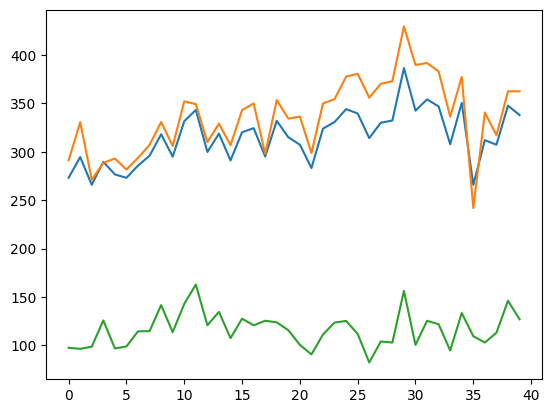

In [48]:
plt.plot(np.arange(40), np.mean(bb_blocks[40:80], axis=1) - 1000)
plt.plot(np.arange(40), np.mean(voc_blocks[40:80], axis=1) - 2000)
plt.plot(np.arange(40), np.mean(sv_blocks[40:80], axis=1))

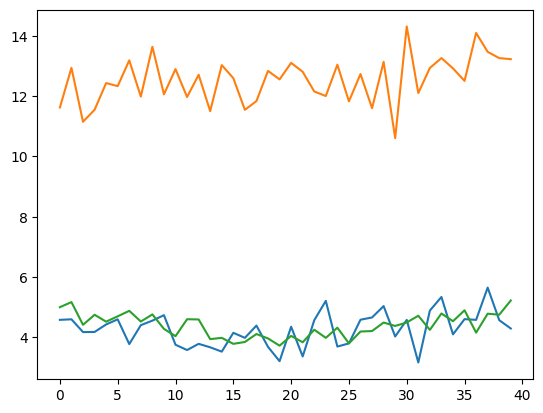

In [45]:
plt.plot(np.arange(40), np.std(bb_blocks[:40], axis=1))
plt.plot(np.arange(40), np.std(voc_blocks[:40], axis=1))
plt.plot(np.arange(40), np.std(sv_blocks[:40], axis=1))

In [35]:
np.std(bb_blocks[0])

4.573426793870094